# Import Libraries

In [269]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_curve, roc_auc_score

from xgboost import XGBClassifier

sns.set_palette(palette='Set1', n_colors=5)

# Import And Examine Data

In [2]:
raw_data = pd.read_csv('data/train.csv')

The data set is based on the [Bank Customer Churn Prediction](https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction) data set. The descriptions of the featues should be understood from it.

Firstl, let's visualize the data types.

In [3]:
display(raw_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


None

First, let's understand the data distribution.

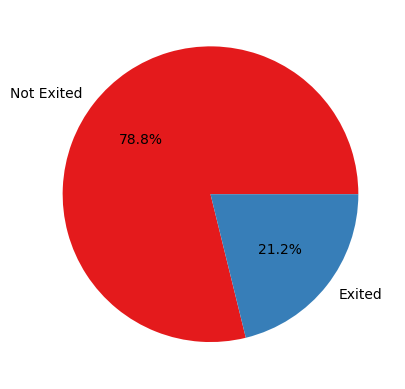

In [7]:
ax = plt.subplot()
ax.pie(raw_data['Exited'].value_counts(), autopct='%1.1f%%', labels = ['Not Exited', 'Exited'])
plt.show()

We can see that the data is imbalanced - there is a much larger set of customers which stay on with the bank.

Let's try to understand which features are more related to the state of staying on with the bank.

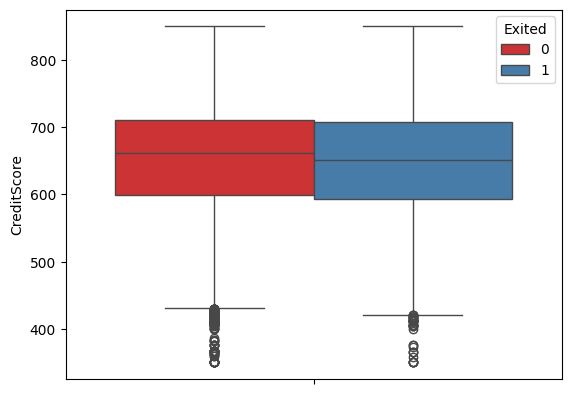

In [14]:
sns.boxplot(raw_data, y='CreditScore', hue='Exited')
plt.show()

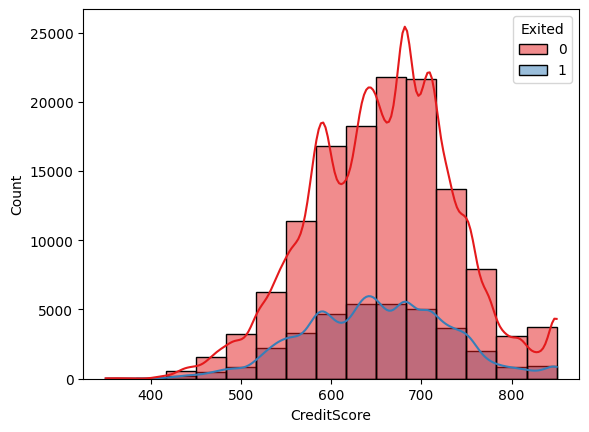

In [267]:
sns.histplot(raw_data, x='CreditScore', hue='Exited', kde=True, bins=15)
plt.show()

What we can see is that there is difference in the data distribution of the customer churn based on the credit score. So `CrditScore` is an great inidcator.

Next up are the categorical fetures of `Geography` and `Gender`.

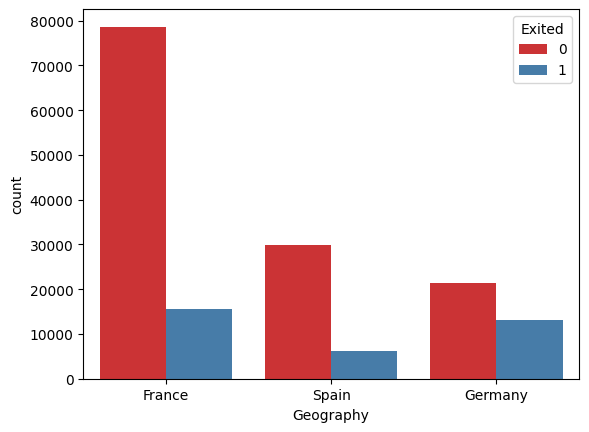

In [13]:
sns.countplot(raw_data, x='Geography', hue='Exited')
plt.show()

We can see that the grography also has an impact on how likley the customers are likely to stop using a bank. Especailly in Germany.

Now, let's understand the gender data.

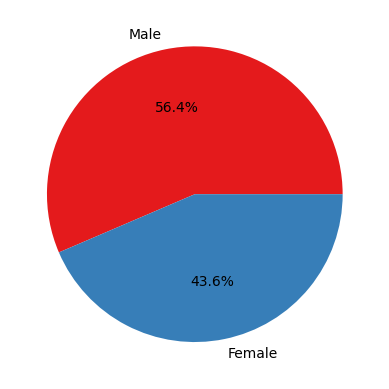

In [197]:
ax = plt.subplot()
ax.pie(raw_data['Gender'].value_counts(), autopct='%1.1f%%', labels = ['Male', 'Female'])
plt.show()

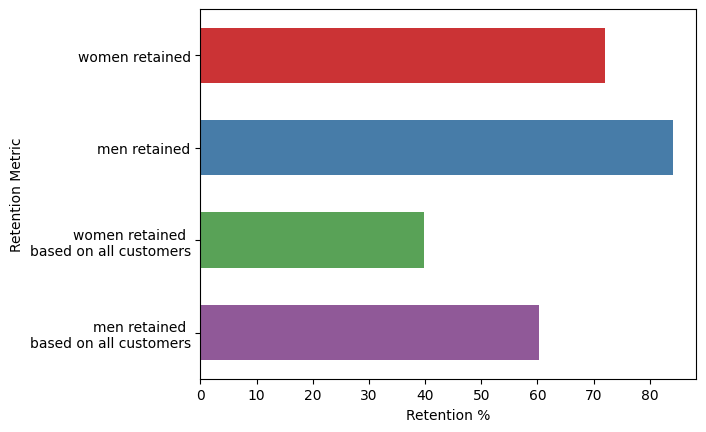

In [228]:
gender_data = raw_data['Gender'].value_counts()
exited_data = raw_data['Exited'].value_counts()
exited_gender_data = raw_data.groupby(['Exited', 'Gender']).count()

gender_data_map = {
    'metric': [],
    'value': []
}
gender_data_map['metric'].append('women retained')
gender_data_map['value'].append((exited_gender_data.loc[(0, 'Female'), 'id'] / gender_data['Female']) * 100)

gender_data_map['metric'].append('men retained')
gender_data_map['value'].append((exited_gender_data.loc[(0, 'Male'), 'id'] / gender_data['Male']) * 100)

gender_data_map['metric'].append('women retained \nbased on all customers')
gender_data_map['value'].append((exited_gender_data.loc[(0, 'Female'), 'id'] / exited_data[0]) * 100)

gender_data_map['metric'].append('men retained \nbased on all customers')
gender_data_map['value'].append((exited_gender_data.loc[(0, 'Male'), 'id'] / exited_data[0]) * 100)

gender_data_df = pd.DataFrame(gender_data_map)

ax = sns.barplot(gender_data_df, y='metric', x='value', hue='metric', width=0.6)
ax.set(xlabel='Retention %', ylabel='Retention Metric')
plt.show()

From the above, we can see that there is a larger number of male customers staying on with the bank, as opposed to women both when considered separately per gender and when consider against the total number of customers that stay on.

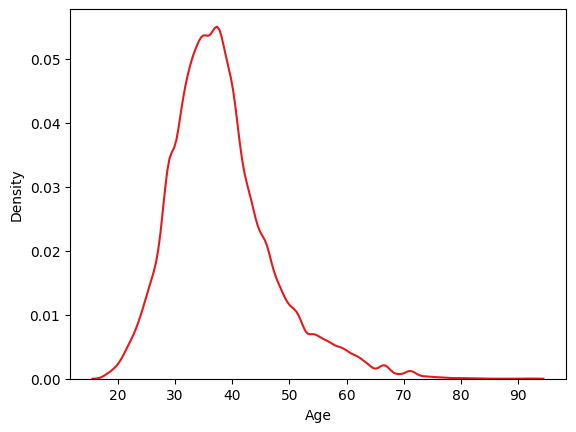

In [115]:
sns.kdeplot(data=raw_data, x="Age", bw_adjust=1)
plt.show()

We can see the age distribuion, which is sekewed more towards customers in the age range between 30 and 40. A logarithm will be applied to normalize the data before analysis. See the visual example below.

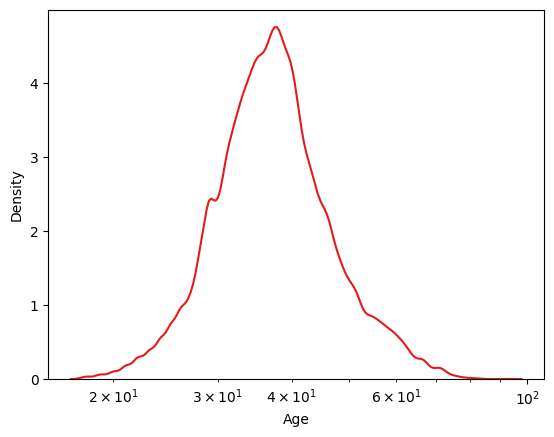

In [117]:
sns.kdeplot(data=raw_data, x="Age", bw_adjust=1, log_scale=True)
plt.show()

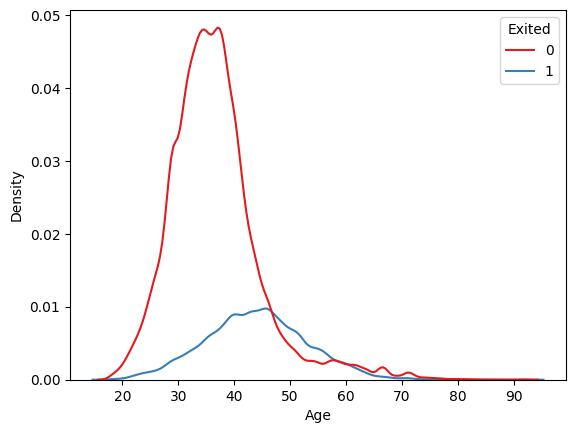

In [119]:
sns.kdeplot(data=raw_data, x="Age", hue='Exited', bw_adjust=1)
plt.show()

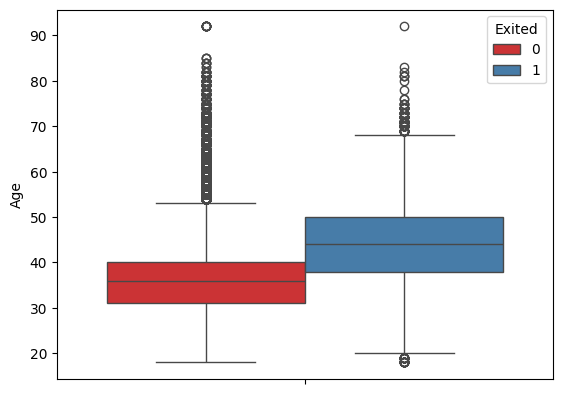

In [105]:
sns.boxplot(data=raw_data, y="Age", hue='Exited')
plt.show()

From the distribution of the data, we can see that the Age is a factor in whether a customer decides to stay on or not.

In the case of those that leave, an older client is less likely to stay on. My suspicion is that older customers are more likely to have greater wealth and as such prefer to take their money to banks that offer smaller taxes and better financial tools.

Now let's understand whether `Tenure` is a predictor of whether customers would be more likley to stay on or not.

The approach is to plot the per cent of customers with a concrete `Tenure` that have been retained by the bank.

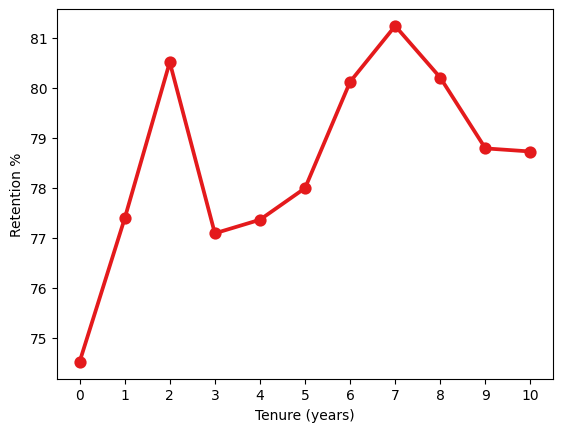

In [230]:
exited_tenure_data = raw_data.groupby(['Exited', 'Tenure']).count()
tenures = raw_data['Tenure'].value_counts()

tenure_retention_map = {
    'tenure': [],
    'tenure_retention': []
}
for i in range(tenures.size):
    tenure_retention = (exited_tenure_data['id'].loc[(0, i)] / tenures.loc[(i)]) * 100
    tenure_retention_map['tenure'].append(i)
    tenure_retention_map['tenure_retention'].append(tenure_retention)

tenure_retention_df = pd.DataFrame(tenure_retention_map)

ax = sns.pointplot(tenure_retention_df, y='tenure_retention', x='tenure')
ax.set(xlabel='Tenure (years)', ylabel='Retention %')
plt.show()

The `y` axis plots the per cent of retained customers while the `x` axis plots the `Tenure` in years.

We can see that `Tenure` is in fact not a particulary great indicator of retention - there is a small differences in the likelihood of a customer staying on based on Tenure. 

We can additionally derive the variance of the data to get a better understanding:

In [231]:
np.var(tenure_retention_df['tenure_retention'].values)

3.4444973449852627

We can see that there is a very small variance. Hence, we can conclude that there is likley very little effect that `Tenure` will have on predciting the customer churn.

Now le'ts try to understand if `Balance` is an indicator of churn.

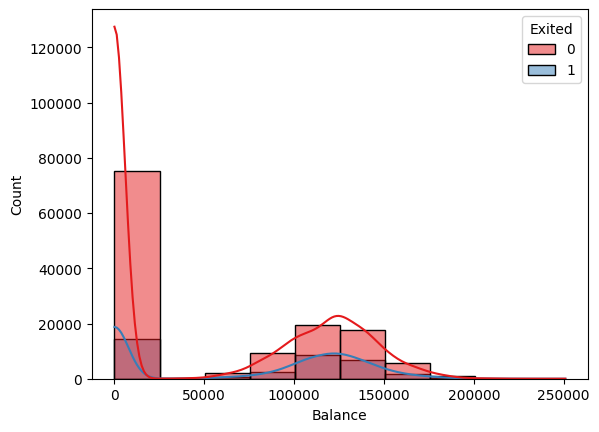

In [256]:
sns.histplot(data=raw_data, x="Balance", hue='Exited', kde=True, bins=10)
plt.show()

The above chart plots the likelihood of customers with specific volumes of money in the bank staying and moving on.

We can see that the likelihood of customers moving away varies based on balance and also is a lot less liekly to occur when the customer has a larger amount of money deposited.

Let's understand how `NumOfproducts` affects the churn rate.

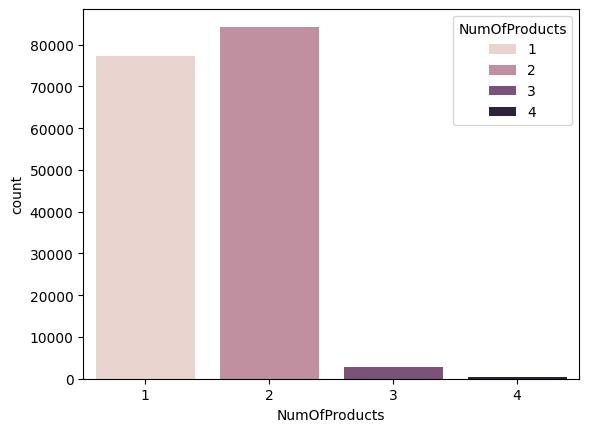

In [234]:
sns.countplot(raw_data, x='NumOfProducts', hue='NumOfProducts')
plt.show()

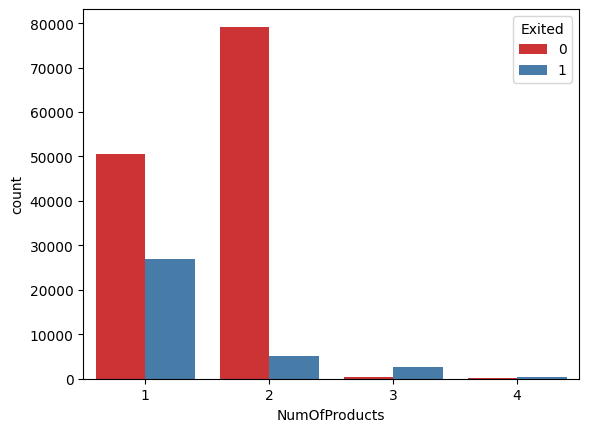

In [190]:
sns.countplot(raw_data, x='NumOfProducts', hue='Exited')
plt.show()

Almost all custromers use 1 or 2 products. We can see that that customers with 1 product are about 60% likely to stay on. When using 2 products, it appears that customers tend to predominantly stay on with the bank. With 3 products, customers are actually more likely to move on to a different banl. Customers with 4 products appear to be evenly split between moving on and staying on.

Customers that use a single product could more easily be convinved to change banks because they do not require sophisticated or special finanacial instruments to manage their wealth. They could be concerned perdominantly with fees and taxes applied by the bank on transactions. Hence, changing banks does not require greater delibaration.

Customers with 2 products could be satisfied with the avaible financial instruments and could be more likely to stay on.

Customers with 3 or moe products could have more specialized needs. They could be more inclined to change to a different bank where there specialized needs are met.

Now let's understand if the having a credit card plays a role in customer retention.

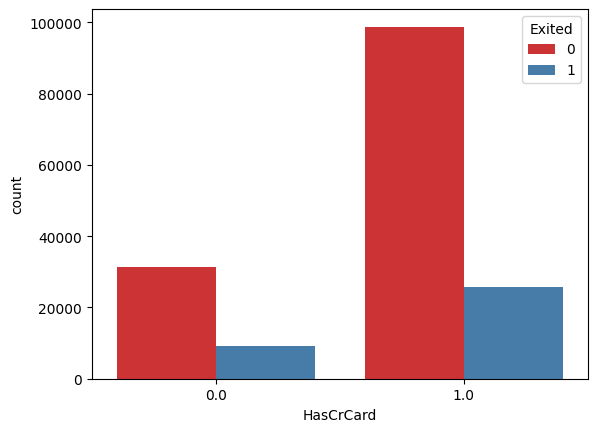

In [235]:
sns.countplot(raw_data, x='HasCrCard', hue='Exited')
plt.show()

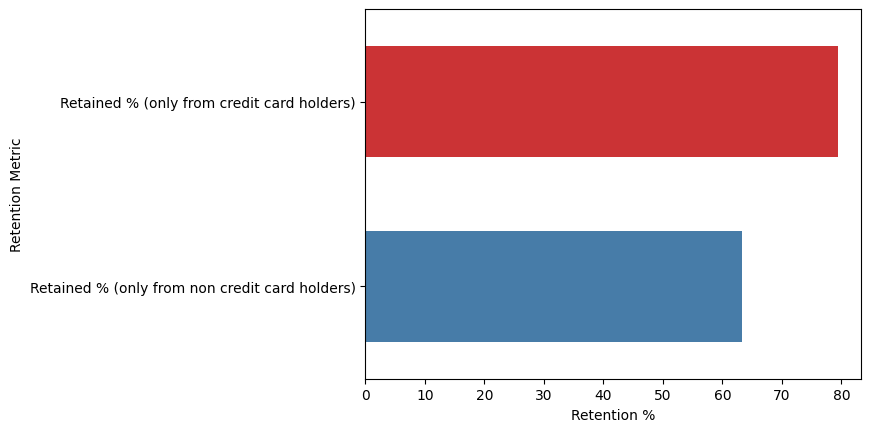

In [243]:
credit_card_holders_count = raw_data['HasCrCard'].value_counts()
credit_card_exited = raw_data[['HasCrCard', 'Exited']].value_counts()

data_map = {
    'metric': [],
    'value': []
}
data_map['metric'].append('Retained % (only from credit card holders)')
data_map['value'].append((credit_card_exited.loc[(1.0, 0)]/credit_card_holders_count.loc[(1.0)])*100)

data_map['metric'].append('Retained % (only from non credit card holders)')
data_map['value'].append((credit_card_exited.loc[(1.0, 1)]/credit_card_holders_count.loc[(0.0)])*100)

credit_card_data_df = pd.DataFrame(data_map)

ax = sns.barplot(credit_card_data_df, y='metric', x='value', hue='metric', width=0.6)
ax.set(xlabel='Retention %', ylabel='Retention Metric')
plt.show()

There is a ~16% difference in the retention based on card holder status. Hence, having a credit card could be considered a basis for determining customer churn. Card hodlers are more likely to stay on as they are additionally concerned with fees and taxes on their credit card. To move to a different bank, they will need to be offered better conditions.

Next to consider is whether being an active member is an indicator of staying on or not.

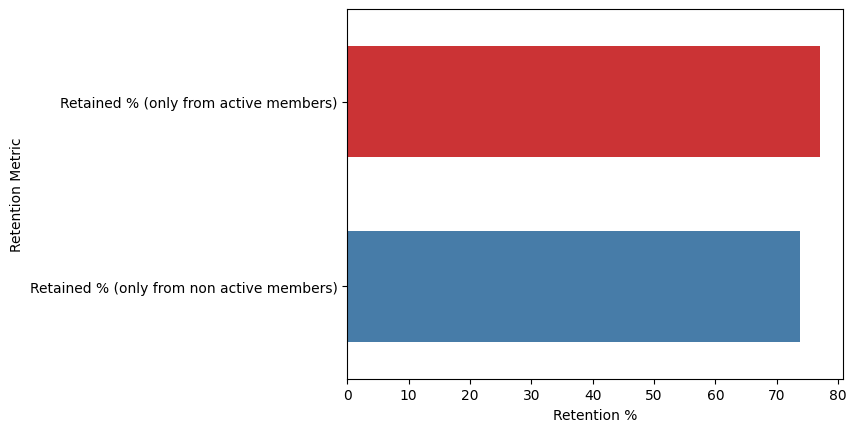

In [245]:
active_members_count = raw_data['IsActiveMember'].value_counts()
active_members_exited = raw_data[['HasCrCard', 'IsActiveMember']].value_counts()

data_map = {
    'metric': [],
    'value': []
}
data_map['metric'].append('Retained % (only from active members)')
data_map['value'].append((active_members_exited.loc[(1.0, 0.0)]/active_members_count.loc[(1.0)])*100)

data_map['metric'].append('Retained % (only from non active members)')
data_map['value'].append((active_members_exited.loc[(1.0, 1.0)]/active_members_count.loc[(0.0)])*100)

active_members_df = pd.DataFrame(data_map)

ax = sns.barplot(active_members_df, y='metric', x='value', hue='metric', width=0.6)
ax.set(xlabel='Retention %', ylabel='Retention Metric')
plt.show()

As can be seen, whether a customer is an active member or not does not determine churn well. As such, this metric will be left out during the modelling phase.

The last feature to consider is `EstimatedSalary`.

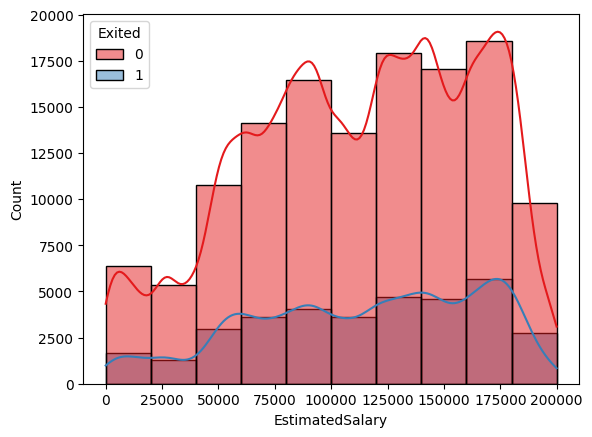

In [262]:
sns.histplot(data=raw_data, x="EstimatedSalary", hue='Exited', kde=True, bins=10)
plt.show()

At first glance, it appears that the highr the salary, the greater the likelihood to stay on with the bank. Hence, salary is a determining factor in customer churn.

# Data Preparation And Analysis

Now, let's move on to the model.

The first thing to do is to encode the data and to handle missing integer values. We will apply the transofrmations on the entire data set at first and build a baseline model with all of the features. Afterwards, the postulations from the previous explorations will be applied by removing features that appear to be weakly related to customer churn.

In [268]:
categorical_columns = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
meta_columns = ['id', 'CustomerId', 'Surname']

encode = OneHotEncoder(sparse_output=False).set_output(transform='pandas')

one_hot_encoded=encode.fit_transform(raw_data[categorical_columns])
baseline_data = pd.concat([raw_data,one_hot_encoded],axis=1).drop(columns=(categorical_columns + meta_columns))

display(baseline_data.head())

,CreditScore,Age,Tenure,Balance,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,HasCrCard_0.0,HasCrCard_1.0,IsActiveMember_0.0,IsActiveMember_1.0,NumOfProducts_1,NumOfProducts_2,NumOfProducts_3,NumOfProducts_4
0,668,33.0,3,0.00,181449.97,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1,627,33.0,1,0.00,49503.50,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,678,40.0,10,0.00,184866.69,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
3,581,34.0,2,148882.54,84560.88,0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
4,716,33.0,5,0.00,15068.83,0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [271]:
X_encoded = baseline_data.drop(columns='Exited')
y = baseline_data['Exited']

X_train, X_test, y_train, y_test = train_test_split(X_encoded, 
                                                    y, 
                                                    random_state=42, 
                                                    stratify=y,
                                                    train_size=0.8)

In [272]:
classifier = XGBClassifier(objective='binary:logistic', seed=42)

classifier.fit(X_train, y_train, verbose=True, early_stopping_rounds=10, eval_metric='aucpr', eval_set=[(X_test, y_test)])

/home/mshtarbev/development/ml-projects/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/home/mshtarbev/development/ml-projects/.venv/lib/python3.11/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-aucpr:0.69347
[1]	validation_0-aucpr:0.70748
[2]	validation_0-aucpr:0.71231
[3]	validation_0-aucpr:0.71553
[4]	validation_0-aucpr:0.71803
[5]	validation_0-aucpr:0.72021
[6]	validation_0-aucpr:0.72245
[7]	validation_0-aucpr:0.72284
[8]	validation_0-aucpr:0.72318
[9]	validation_0-aucpr:0.72400
[10]	validation_0-aucpr:0.72447
[11]	validation_0-aucpr:0.72470
[12]	validation_0-aucpr:0.72543
[13]	validation_0-aucpr:0.72582
[14]	validation_0-aucpr:0.72591
[15]	validation_0-aucpr:0.72590
[16]	validation_0-aucpr:0.72626
[17]	validation_0-aucpr:0.72662
[18]	validation_0-aucpr:0.72639
[19]	validation_0-aucpr:0.72656
[20]	validation_0-aucpr:0.72622
[21]	validation_0-aucpr:0.72643
[22]	validation_0-aucpr:0.72641
[23]	validation_0-aucpr:0.72639
[24]	validation_0-aucpr:0.72658
[25]	validation_0-aucpr:0.72644
[26]	validation_0-aucpr:0.72641


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)